## 2 Dimensional Variational density classification in Tensor Circuit

02 junio 2024

Diego Useche Reyes

## GPU

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Libraries

In [ ]:

!pip install tensorcircuit
!pip install git+https://github.com/diegour1/qmc.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.0/342.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 14.1 MB/s eta 0:00:00
  Cloning https://github.com/diegour1/qmc.git to /tmp/pip-req-build-bn93tmwx
  Running command git clone --filter=blob:none --quiet https://github.com/diegour1/qmc.git /tmp/pip-req-build-bn93tmwx
  Resolved https://github.com/diegour1/qmc.git to commit 4c2db4b21508f28466743eaf0b13fe70814f65dc
  Preparing metadata (setup.py) ... done
  Created wheel for qmc: filename=qmc-0.0.1-py3-none-any.whl size=12988 sha256=27be9dc1ddfc62d2bacc440a235a092110a2afdbe79656458009012506c6fc71
  Stored in directory: /tmp/pip-ephem-wheel-cache-iw13u8_8/wheels/9f/94/66/55600fd5fe039b621ab7ee795c96f41946d90a9efaf4914d6e
Successfully built qmc


In [ ]:
from functools import partial
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
from tabulate import tabulate
import tensorcircuit as tc
from tensorcircuit import keras
from scipy.stats import entropy
import math
import qmc.tf.layers as qmc_layers
import qmc.tf.models as qmc_models

In [ ]:
tc.set_backend("tensorflow")
tc.set_dtype("complex128")

('complex128', 'float64')

## Utils functions

In [ ]:
# Given the eigenvalues this function return a Unitary gate which converts the |0> -> |psi_train>
def create_U_train(x_train_param, seed=0):
  np.random.seed(seed)
  size_U = len(x_train_param)
  U_train = np.zeros((size_U, size_U), dtype = np.complex128)
  x_1 = x_train_param
  U_train[:, 0] = x_1
  for i in range(1, size_U):
    x_i =  np.complex128(np.random.randn(size_U) + 1j*np.random.randn(size_U))
    for j in range(0, i):
      x_i -= x_i.dot(np.conjugate(U_train[:, j])) * U_train[:, j]
    x_i = x_i/np.linalg.norm(x_i)
    U_train[:, i] = x_i

  return U_train

In [ ]:
# this function takes the number of classes and of qubits of the qmc pure, and extract the indices
# of the bit strings that correpond to the classes prediction
def indices_qubits_clases(num_qubits_param, num_classes_param):
  num_qubits_classes_temp = int(np.ceil(np.log2(num_classes_param)))
  a = [np.binary_repr(i, num_qubits_param) for i in range(2**num_qubits_param)]
  b = [(np.binary_repr(i, num_qubits_classes_temp) + "0"*(num_qubits_param - num_qubits_classes_temp)) for i in range(num_classes_param)]
  indices_temp = []
  for i in range(len(a)):
    if a[i] in b:
      indices_temp.append(i)

  return indices_temp

indices_qubits_clases(1, 2)

[0, 1]

In [ ]:
## evaluate conditional density estimation

def evaluate_class_model(y_true_test_param, y_pred_test_kdc_param, y_pred_test_model_param, y_plot_kdc_param, y_plot_model_param, model_name_param):

  # Accuracy kdc
  accuracy_kdc_temp = accuracy_score(y_true_test_param, np.argmax(y_pred_test_kdc_param, axis = 1))

  # Accuracy model
  accuracy_model_temp = accuracy_score(y_true_test_param, np.argmax(y_pred_test_model_param, axis = 1))

  # kullback-Leibler divergence plot
  y_plot_kdc_temp = y_plot_kdc_param.reshape(-1, 1)
  y_plot_model_temp = y_plot_model_param.reshape(-1, 1)
  kldiv_kdc_vs_model = entropy(y_plot_kdc_temp, y_plot_model_temp)

  # mean average error
  absolute_differences_temp = np.abs(y_plot_kdc_temp - y_plot_model_temp)
  average_error_temp = np.mean(absolute_differences_temp)

  # Calculate spearmann correlation per class, i.e., the ranks of the density values
  # spearman class 0
  ranks1_class0 = np.array(y_plot_kdc_param[:, 0]).argsort().argsort()
  ranks2_class0 = y_plot_model_param[:, 0].argsort().argsort()
  # spearman class 1
  ranks1_class1 = np.array(y_plot_kdc_param[:, 1]).argsort().argsort()
  ranks2_class1 = y_plot_model_param[:, 1].argsort().argsort()

  # Calculate the Spearman correlation
  spearman_corr_class0, _ = spearmanr(ranks2_class0, ranks1_class0)
  spearman_corr_class1, _ = spearmanr(ranks2_class1, ranks1_class1)

  # build table
  table = [["Accuracy KDC:", np.round(accuracy_kdc_temp,3)], [f"Accuracy {model_name_param}:", np.round(accuracy_model_temp,3)], [f"KL-div KDC vs {model_name_param}:", np.round(kldiv_kdc_vs_model,3)], [f"MAE KDC vs {model_name_param}:", np.round(average_error_temp,3)], [f"Spearmann class 0 KDC vs {model_name_param}:", np.round(spearman_corr_class0,3)], [f"Spearmann class 1 KDC vs {model_name_param}:", np.round(spearman_corr_class1, 3)]]
  headers = ['Metrics', f"KDC vs {model_name_param}"]
  print(tabulate(table, headers), "\n")

In [ ]:
%matplotlib inline
import numpy as np
import pylab as pl

# Function to visualize a 2D dataset
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")

# Function to visualize the decission surface of a classifier
def plot_decision_region(X_param, preds_plot_param):
    min_x = np.min(X_param[:, 0])
    max_x = np.max(X_param[:, 0])
    min_y = np.min(X_param[:, 1])
    max_y = np.max(X_param[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 20)
    y_vals = np.linspace(min_y, max_y, 20)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape

    ZZ = np.reshape(preds_plot_param[:, 1]/preds_plot_param.sum(axis=1), (grid_r, grid_c))

    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= 0, vmax=1)
    pl.colorbar()
    #CS = pl.contour(XX, YY, ZZ, 100, levels = [0.125*i for i in range(1,8)])
    CS = pl.contour(XX, YY, ZZ, 100, levels = [0.5])
    pl.clabel(CS, inline=1, fontsize=10)
    pl.xlabel("x")
    pl.ylabel("y")

In [ ]:
def save_model(preds_model_train, preds_model_test, preds_model_plot, data_set_param,  model_param, gamma_param, date_param, mode_param = "load"):

  if mode_param == "save":
    np.save(f"/content/drive/MyDrive/Tesis Doctorado/Notebooks/2023/Quantum Measurement Classification with Mixed States/Variational density classification 290424/Results_2D_density_classification_V050624/Results_2D_Classification_{data_set_param}_V{date_param}/{data_set_param}_{model_param}_gamma{gamma_param}_predstrain_V{date_param}.npy", preds_model_train)
    np.save(f"/content/drive/MyDrive/Tesis Doctorado/Notebooks/2023/Quantum Measurement Classification with Mixed States/Variational density classification 290424/Results_2D_density_classification_V050624/Results_2D_Classification_{data_set_param}_V{date_param}/{data_set_param}_{model_param}_gamma{gamma_param}_predstest_V{date_param}.npy", preds_model_test)
    np.save(f"/content/drive/MyDrive/Tesis Doctorado/Notebooks/2023/Quantum Measurement Classification with Mixed States/Variational density classification 290424/Results_2D_density_classification_V050624/Results_2D_Classification_{data_set_param}_V{date_param}/{data_set_param}_{model_param}_gamma{gamma_param}_predsplot_V{date_param}.npy", preds_model_plot)

  else:
    print("No mode error")

def load_model(data_set_param,  model_param, gamma_param, date_param, mode_param = "load"):

  if mode_param == "load":
    preds_model_train_temp = np.load(f"/content/drive/MyDrive/Tesis Doctorado/Notebooks/2023/Quantum Measurement Classification with Mixed States/Variational density classification 290424/Results_2D_density_classification_V050624/Results_2D_Classification_{data_set_param}_V{date_param}/{data_set_param}_{model_param}_gamma{gamma_param}_predstrain_V{date_param}.npy")
    preds_model_test_temp = np.load(f"/content/drive/MyDrive/Tesis Doctorado/Notebooks/2023/Quantum Measurement Classification with Mixed States/Variational density classification 290424/Results_2D_density_classification_V050624/Results_2D_Classification_{data_set_param}_V{date_param}/{data_set_param}_{model_param}_gamma{gamma_param}_predstest_V{date_param}.npy")
    preds_model_plot_temp = np.load(f"/content/drive/MyDrive/Tesis Doctorado/Notebooks/2023/Quantum Measurement Classification with Mixed States/Variational density classification 290424/Results_2D_density_classification_V050624/Results_2D_Classification_{data_set_param}_V{date_param}/{data_set_param}_{model_param}_gamma{gamma_param}_predsplot_V{date_param}.npy")

    return preds_model_train_temp, preds_model_test_temp, preds_model_plot_temp

  else:
    print("No mode error")


## Data sets

### Moons Data Set

In [ ]:
## Download moons data

X, y = make_moons(n_samples=2000, noise=0.2, random_state=0)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=42)
y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]

In [ ]:
## Create grid points

min_x = np.min(X[:, 0])
max_x = np.max(X[:, 0])
min_y = np.min(X[:, 1])
max_y = np.max(X[:, 1])
min_x = min_x - (max_x - min_x) * 0.05
max_x = max_x + (max_x - min_x) * 0.05
min_y = min_y - (max_y - min_y) * 0.05
max_y = max_y + (max_y - min_y) * 0.05
x_vals = np.linspace(min_x, max_x, 20)
y_vals = np.linspace(min_y, max_y, 20)
XX, YY = np.meshgrid(x_vals, y_vals)
grid_r, grid_c = XX.shape
X_plot = np.array([[XX[i, j], YY[i, j]] for i in range(grid_r) for j in range(grid_c)])

X_plot.shape

(400, 2)

In [ ]:
## one-hot encoding
encoder = OneHotEncoder(sparse=False)

# One-hot encoding using scikit-learn
y_train_oh = encoder.fit_transform(y_train)
y_test_oh = encoder.fit_transform(y_test)

y_train_oh.shape, y_test_oh.shape

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((1800, 2), (200, 2))

### Circles Data Set

In [ ]:
## Download circles data

X, y = make_circles(n_samples=2000, noise=0.2, random_state=1, factor=0.2)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=42)
y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]

In [ ]:
## Create grid points

min_x = np.min(X[:, 0])
max_x = np.max(X[:, 0])
min_y = np.min(X[:, 1])
max_y = np.max(X[:, 1])
min_x = min_x - (max_x - min_x) * 0.05
max_x = max_x + (max_x - min_x) * 0.05
min_y = min_y - (max_y - min_y) * 0.05
max_y = max_y + (max_y - min_y) * 0.05
x_vals = np.linspace(min_x, max_x, 20)
y_vals = np.linspace(min_y, max_y, 20)
XX, YY = np.meshgrid(x_vals, y_vals)
grid_r, grid_c = XX.shape
X_plot = np.array([[XX[i, j], YY[i, j]] for i in range(grid_r) for j in range(grid_c)])

X_plot.shape

(400, 2)

In [ ]:
## one-hot encoding
encoder = OneHotEncoder(sparse=False)

# One-hot encoding using scikit-learn
y_train_oh = encoder.fit_transform(y_train)
y_test_oh = encoder.fit_transform(y_test)

y_train_oh.shape, y_test_oh.shape

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((1800, 2), (200, 2))

### Spirals Data Set

In [ ]:
def make_spirals(num, noise, spirality, random_state=0):
    np.random.seed(random_state)
    noise_ = np.linspace(0.1, 3, num//2)*np.random.randn(num//2)*noise
    r = np.sort(np.random.rand(num//2) + 2)**3 + noise_ - 5
    theta1 = np.random.rand()*2*np.pi
    thetas = theta1 + np.cumsum(np.linspace(0.01+spirality, 0.01, num//2))
    X1 = r * np.cos(thetas)
    Y1 = r * np.sin(thetas)

    noise_ = np.linspace(0.1, 3, num-num//2)*np.random.randn(num-num//2)*noise
    r = np.sort(np.random.rand(num - num//2) + 2)**3 + noise_ - 5
    theta2 = theta1 + np.pi
    thetas = theta2 + np.cumsum(np.linspace(0.01+spirality, 0.01, num -num//2))
    X2 = r * np.cos(thetas)
    Y2 = r * np.sin(thetas)
    X = np.vstack((X1, Y1)).T
    X = np.vstack((X, np.vstack((X2, Y2)).T))
    y = np.hstack((np.ones(num//2), np.zeros(num - num//2)))
    return X, y

X, y = make_spirals(1000, noise=0.5, spirality=1/40, random_state=0)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=42)
y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]

In [ ]:
## Create grid points

min_x = np.min(X[:, 0])
max_x = np.max(X[:, 0])
min_y = np.min(X[:, 1])
max_y = np.max(X[:, 1])
min_x = min_x - (max_x - min_x) * 0.05
max_x = max_x + (max_x - min_x) * 0.05
min_y = min_y - (max_y - min_y) * 0.05
max_y = max_y + (max_y - min_y) * 0.05
x_vals = np.linspace(min_x, max_x, 20)
y_vals = np.linspace(min_y, max_y, 20)
XX, YY = np.meshgrid(x_vals, y_vals)
grid_r, grid_c = XX.shape
X_plot = np.array([[XX[i, j], YY[i, j]] for i in range(grid_r) for j in range(grid_c)])

X_plot.shape

(400, 2)

In [ ]:
## one-hot encoding
encoder = OneHotEncoder(sparse=False)

# One-hot encoding using scikit-learn
y_train_oh = encoder.fit_transform(y_train)
y_test_oh = encoder.fit_transform(y_test)

y_train_oh.shape, y_test_oh.shape

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((900, 2), (100, 2))

## Constants

In [ ]:
## Change these values accordingly

DATA_SET = "Spirals" ## change dataset accordingly
NUM_QUBITS_FFS = 5 ## set 5 for the final experiments
NUM_ANCILLA_QUBITS = 2 # set 2 for the final experiment
GRID_SIZE = X_plot[1] - X_plot[0]
NUM_CLASSES = 2
NUM_CLASSES_QUBITS = 1
BATCH_SIZE = 16

#######

GAMMA_DICT = {"Moons": float(2**7), "Circles": float(2**6), "Spirals": float(2**8)}
GAMMA_STRING_DICT = {"Moons": "2ala7", "Circles": "2ala6", "Spirals": "2ala8"}
RANDOM_STATE_QRFF_DICT = {"Moons": 324, "Circles": 125, "Spirals": 345}
RANDOM_STATE_QEFF_DICT = {"Moons": 3, "Circles": 15, "Spirals": 56}
EPOCHS_DICT  = {"Moons": 50, "Circles": 100, "Spirals": 200}
LEARNING_RATE_DICT = {"Moons": 0.002, "Circles": 0.001, "Spirals": 0.001}
GAMMA = GAMMA_DICT[DATA_SET]
GAMMA_STRING = GAMMA_STRING_DICT[DATA_SET]
RANDOM_STATE_QRFF = RANDOM_STATE_QRFF_DICT[DATA_SET]
RANDOM_STATE_QEFF = RANDOM_STATE_QEFF_DICT[DATA_SET]
LEARNING_RATE = LEARNING_RATE_DICT[DATA_SET]
EPOCHS = EPOCHS_DICT[DATA_SET]
DIM_X = X_train.shape[1]
N_TRAINING_DATA = X_train.shape[0]
N_FFS = 2**NUM_QUBITS_FFS

###

DATA_SET, EPOCHS, NUM_QUBITS_FFS, NUM_ANCILLA_QUBITS, GAMMA, RANDOM_STATE_QRFF, RANDOM_STATE_QEFF, DIM_X, N_FFS, LEARNING_RATE, N_TRAINING_DATA, GAMMA_STRING

('Spirals', 200, 5, 2, 256.0, 345, 56, 2, 32, 0.001, 900, '2ala8')

## Raw KDC

In [ ]:
def kernel_density_classification(X_train_param, Y_train_oh_param, X_test_param, gamma_param = 4.):

  ## Initialize values
  Y_train_oh_param = np.array(Y_train_oh_param)
  num_classes_temp = Y_train_oh_param.shape[1]
  Y_pred_temp = np.zeros((len(X_test_param), num_classes_temp))
  sigma_temp = 1./(np.sqrt(2.*gamma_param))

  ## Training
  kde_temp = []
  for j in range(num_classes_temp):
    try:
      kde_temp.append(KernelDensity(kernel='gaussian', bandwidth=sigma_temp).fit(X_train_param[Y_train_oh_param[:, j].astype(bool)]))
    except:
      pass
  ## Prediction
  for j in range(num_classes_temp):
    try:
      Y_pred_temp[:, j] =  (Y_train_oh_param[:, j].sum()/len(Y_train_oh_param))*np.exp(kde_temp[j].score_samples(X_test_param))
    except:
      pass
  return Y_pred_temp

preds_train_kdc = kernel_density_classification(X_train, y_train_oh, X_train, gamma_param = GAMMA)
preds_test_kdc = kernel_density_classification(X_train, y_train_oh, X_test, gamma_param = GAMMA)
preds_plot_kdc = kernel_density_classification(X_train, y_train_oh, X_plot, gamma_param = GAMMA)

In [ ]:
### Evaluate model

evaluate_class_model(y_true_test_param = y_test, y_pred_test_kdc_param = preds_test_kdc, y_pred_test_model_param = preds_test_kdc, y_plot_kdc_param = preds_plot_kdc, y_plot_model_param = preds_plot_kdc, model_name_param = "KDC")

Metrics                          KDC vs KDC
-----------------------------  ------------
Accuracy KDC:                             1
Accuracy KDC:                             1
KL-div KDC vs KDC:                        0
MAE KDC vs KDC:                           0
Spearmann class 0 KDC vs KDC:             1
Spearmann class 1 KDC vs KDC:             1 



<ipython-input-9-9cba43dc4532>:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,


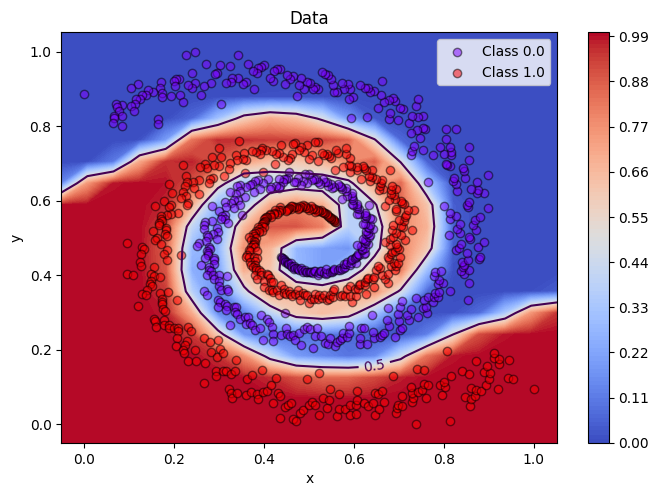

In [ ]:
pl.figure(figsize = (8,16/3))
plot_decision_region(X, preds_plot_kdc)
plot_data(X, y)

In [ ]:
### save or load the model
mode_temp = "load"
date_temp = "050624"
model_temp = "kdc"
data_set_temp = "Spirals"

if mode_temp == "save":
  save_model(preds_model_train = preds_train_kdc, preds_model_test = preds_test_kdc, preds_model_plot = preds_plot_kdc, data_set_param = data_set_temp,  model_param = model_temp, gamma_param = GAMMA_STRING, date_param = date_temp, mode_param = mode_temp)
elif mode_temp == "load":
  preds_train_kdc, preds_test_kdc, preds_plot_kdc = load_model(data_set_param = data_set_temp,  model_param = model_temp, gamma_param = GAMMA_STRING, date_param = date_temp, mode_param = mode_temp)

## Classical DMKDC QRFF

In [ ]:
def classical_dmkdc_qrff(X_train_param, Y_train_oh_param, X_test_param, n_qrffs_param, rs_param, gamma_param = 4.):

  ## Initialize values
  dim_x_temp = X_train_param.shape[1]
  Y_train_oh_param = np.array(Y_train_oh_param)
  num_classes_temp = Y_train_oh_param.shape[1]
  Y_pred_temp = np.zeros((len(X_test_param), num_classes_temp))
  sigma_temp = 1./(np.sqrt(2.*gamma_param))

  ## Training
  dmkdc_temp = []
  for j in range(num_classes_temp):
    try:
      fm_x = qmc_layers.QFeatureMapComplexRFF(dim_x_temp, dim=n_qrffs_param, gamma=gamma_param/2, random_state= rs_param)
      dmkdc_temp.append(qmc_models.ComplexQMDensity(fm_x, n_qrffs_param))
    except:
      pass
  ## Prediction
  for j in range(num_classes_temp):
    try:
      dmkdc_temp[j].compile()
      dmkdc_temp[j].fit(X_train_param[Y_train_oh_param[:, j].astype(bool)], epochs=1)
      Y_pred_temp[:, j] = ((gamma_param/np.pi)**(dim_x_temp/2))*(dmkdc_temp[j].predict(X_test_param))
    except:
      pass

  return ((Y_train_oh_param.sum(axis=0)/len(Y_train_oh_param)))*Y_pred_temp

preds_train_dmkdc = classical_dmkdc_qrff(X_train, y_train_oh, X_train, n_qrffs_param = N_FFS, rs_param = RANDOM_STATE_QRFF, gamma_param = GAMMA)
preds_test_dmkdc = classical_dmkdc_qrff(X_train, y_train_oh, X_test, n_qrffs_param = N_FFS, rs_param = RANDOM_STATE_QRFF, gamma_param = GAMMA)
preds_plot_dmkdc = classical_dmkdc_qrff(X_train, y_train_oh, X_plot, n_qrffs_param = N_FFS, rs_param = RANDOM_STATE_QRFF, gamma_param = GAMMA)

29/29 [==============================] - 0s 2ms/step


<ipython-input-108-80da1472adbe>:23: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_pred_temp[:, j] = ((gamma_param/np.pi)**(dim_x_temp/2))*(dmkdc_temp[j].predict(X_test_param))


29/29 [==============================] - 0s 2ms/step


<ipython-input-108-80da1472adbe>:23: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_pred_temp[:, j] = ((gamma_param/np.pi)**(dim_x_temp/2))*(dmkdc_temp[j].predict(X_test_param))


4/4 [==============================] - 0s 3ms/step


<ipython-input-108-80da1472adbe>:23: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_pred_temp[:, j] = ((gamma_param/np.pi)**(dim_x_temp/2))*(dmkdc_temp[j].predict(X_test_param))


4/4 [==============================] - 0s 3ms/step


<ipython-input-108-80da1472adbe>:23: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_pred_temp[:, j] = ((gamma_param/np.pi)**(dim_x_temp/2))*(dmkdc_temp[j].predict(X_test_param))


13/13 [==============================] - 0s 2ms/step


<ipython-input-108-80da1472adbe>:23: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_pred_temp[:, j] = ((gamma_param/np.pi)**(dim_x_temp/2))*(dmkdc_temp[j].predict(X_test_param))


13/13 [==============================] - 0s 2ms/step


<ipython-input-108-80da1472adbe>:23: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_pred_temp[:, j] = ((gamma_param/np.pi)**(dim_x_temp/2))*(dmkdc_temp[j].predict(X_test_param))


In [ ]:
### Evaluate model
evaluate_class_model(y_true_test_param = y_test, y_pred_test_kdc_param = preds_test_kdc, y_pred_test_model_param = preds_test_dmkdc, y_plot_kdc_param = preds_plot_kdc, y_plot_model_param = preds_plot_dmkdc, model_name_param = "Classical DMKDC 32 QRFF")

Metrics                                              KDC vs Classical DMKDC 32 QRFF
-------------------------------------------------  --------------------------------
Accuracy KDC:                                                                 1
Accuracy Classical DMKDC 32 QRFF:                                             0.99
KL-div KDC vs Classical DMKDC 32 QRFF:                                        0.668
MAE KDC vs Classical DMKDC 32 QRFF:                                           1.544
Spearmann class 0 KDC vs Classical DMKDC 32 QRFF:                             0.658
Spearmann class 1 KDC vs Classical DMKDC 32 QRFF:                             0.637 



<ipython-input-9-9cba43dc4532>:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,


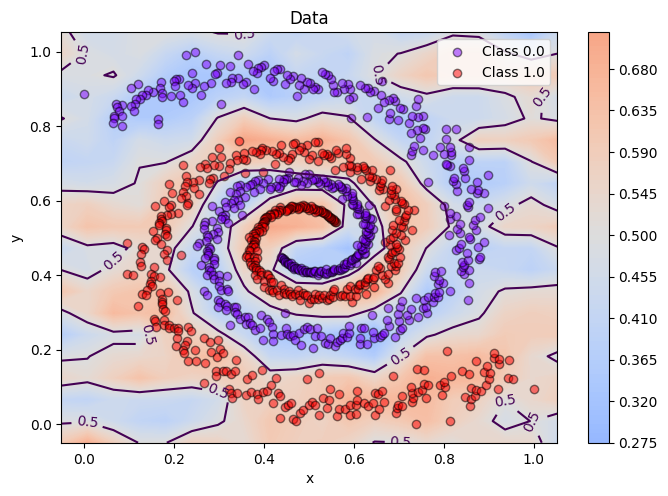

In [ ]:
pl.figure(figsize = (8,16/3))
plot_decision_region(X, preds_plot_dmkdc)
plot_data(X, y)

In [ ]:
### save or load the model
mode_temp = "load"
date_temp = "050624"
model_temp = "dmkdc_32qrff"
data_set_temp = "Spirals"

if mode_temp == "save":
  save_model(preds_model_train = preds_train_dmkdc, preds_model_test = preds_test_dmkdc, preds_model_plot = preds_plot_dmkdc, data_set_param = data_set_temp,  model_param = model_temp, gamma_param = GAMMA_STRING, date_param = date_temp, mode_param = mode_temp)
elif mode_temp == "load":
  preds_train_dmkdc, preds_test_dmkdc, preds_plot_dmkdc = load_model(data_set_param = data_set_temp,  model_param = model_temp, gamma_param = GAMMA_STRING, date_param = date_temp, mode_param = mode_temp)

## Classical DMKDC QEFF

In [ ]:
import qmc.tf.layers as qmc_layers
import qmc.tf.models as qmc_models

In [ ]:

tc.set_backend("tensorflow")
tc.set_dtype("complex128")

class QFeatureMapQuantumEnhancedFF(tf.keras.layers.Layer):
    """Quantum feature map including the complex part of random Fourier Features.
    Uses `RBFSampler` from sklearn to approximate an RBF kernel using
    complex random Fourier features.

    Input shape:
        (batch_size, dim_in)
    Output shape:
        (batch_size, dim)
    Arguments:
        input_dim: dimension of the input
        dim: int. Number of dimensions to represent a sample.
        gamma: float. Gamma parameter of the RBF kernel to be approximated.
        random_state: random number generator seed.
    """

    def __init__(
            self,
            input_dim: int,
            dim: int = 100,
            gamma: float = 0.5,
            random_state=None,
            **kwargs
    ):
        super().__init__(**kwargs)
        self.input_dim = input_dim
        self.dim = dim
        self.gamma = gamma
        self.random_state = random_state


    def build(self, input_shape):
        self.qeff_weights = tf.random.normal((self.input_dim, int(self.dim*1-1)), mean = 0.0, stddev = 2.0/np.sqrt(self.dim - 1), dtype=tf.dtypes.float64, seed = self.random_state) ## final model self.qeff_weights = tf.random.normal((self.input_dim, int(self.dim*1-1)), mean = 0.0, stddev = 2.0/np.sqrt(self.dim - 1), dtype=tf.dtypes.float64, seed = self.random_state)
        self.built = True

    def call(self, inputs):

        ### build the phases of QEFF
        phases_temp = (tf.cast(tf.sqrt(self.gamma), tf.float64)*tf.linalg.matmul(tf.cast(inputs, tf.float64), self.qeff_weights))[0]

        ### indices qeff for iterator
        index_iter_qeff = iter(np.arange(self.qeff_weights.shape[1]))

        ## build QEFF circuit
        self.n_qeff_qubits = int(np.ceil(np.log2(self.dim)))
        self.circuit = tc.Circuit(self.n_qeff_qubits)

        def circuit_base_rz_qeff_n(qc_param, num_qubits_param, target_qubit_param):
          if num_qubits_param == 1:
            qc_param.rz(0, theta = phases_temp[next(index_iter_qeff)] )
          elif num_qubits_param == 2:
            qc_param.rz(target_qubit_param, theta = phases_temp[next(index_iter_qeff)])
            qc_param.cnot(0, target_qubit_param)
            qc_param.rz(target_qubit_param, theta = phases_temp[next(index_iter_qeff)])
            return
          else:
            circuit_base_rz_qeff_n(qc_param, num_qubits_param-1, target_qubit_param)
            qc_param.cnot(num_qubits_param-2, target_qubit_param)
            circuit_base_rz_qeff_n(qc_param, num_qubits_param-1, target_qubit_param)
            target_qubit_param -= 1

        # Applying the QEFF feature map

        for i in range(0, self.n_qeff_qubits):
          self.circuit.H(i)

        for i in range(1, self.n_qeff_qubits + 1):
          circuit_base_rz_qeff_n(self.circuit, i, i - 1)

        psi = tf.cast(tf.expand_dims(self.circuit.state(), axis=0), tf.complex64)
        return psi

    def get_config(self):
        config = {
            "input_dim": self.input_dim,
            "dim": self.dim,
            "gamma": self.gamma,
            "random_state": self.random_state
        }
        base_config = super().get_config()
        return {**base_config, **config}

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dim)

In [ ]:
def classical_dmkdc_qeff(X_train_param, Y_train_oh_param, X_test_param, n_qrffs_param, rs_param, gamma_param = 4.):

  ## Initialize values
  dim_x_temp = X_train_param.shape[1]
  Y_train_oh_param = np.array(Y_train_oh_param)
  num_classes_temp = Y_train_oh_param.shape[1]
  Y_pred_temp = np.zeros((len(X_test_param), num_classes_temp))
  sigma_temp = 1./(np.sqrt(2.*gamma_param))

  ## Training
  dmkdc_temp = []
  fm_x = QFeatureMapQuantumEnhancedFF(dim_x_temp, dim=n_qrffs_param, gamma=gamma_param, random_state= rs_param)
  for j in range(num_classes_temp):
    try:
      dmkdc_temp.append(qmc_models.ComplexQMDensity(fm_x, n_qrffs_param))
    except:
      pass

  ## Prediction
  for j in range(num_classes_temp):
    try:
      dmkdc_temp[j].compile()
      dmkdc_temp[j].fit(X_train_param[Y_train_oh_param[:, j].astype(bool)], epochs=1, batch_size = 1) ### must keep the batch size = 1
      Y_pred_temp[:, j] = ((gamma_param/np.pi)**(dim_x_temp/2))*(dmkdc_temp[j].predict(X_test_param, batch_size = 1)) ### must keep the batch size = 1
    except:
      pass
  return ((Y_train_oh_param.sum(axis=0)/len(Y_train_oh_param)))*Y_pred_temp

preds_train_dmkdc_qeff = classical_dmkdc_qeff(X_train, y_train_oh, X_train, n_qrffs_param = N_FFS, rs_param = RANDOM_STATE_QEFF, gamma_param = GAMMA)
preds_test_dmkdc_qeff = classical_dmkdc_qeff(X_train, y_train_oh, X_test, n_qrffs_param = N_FFS, rs_param = RANDOM_STATE_QEFF, gamma_param = GAMMA)
preds_plot_dmkdc_qeff = classical_dmkdc_qeff(X_train, y_train_oh, X_plot, n_qrffs_param = N_FFS, rs_param = RANDOM_STATE_QEFF, gamma_param = GAMMA)

100/100 [==============================] - 9s 2ms/step


<ipython-input-17-cbf804601fe1>:24: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_pred_temp[:, j] = ((gamma_param/np.pi)**(dim_x_temp/2))*(dmkdc_temp[j].predict(X_test_param, batch_size = 1)) ### must keep the batch size = 1


400/400 [==============================] - 9s 2ms/step


In [ ]:
### Evaluate model
evaluate_class_model(y_true_test_param = y_test, y_pred_test_kdc_param = preds_test_kdc, y_pred_test_model_param = preds_test_dmkdc_qeff, y_plot_kdc_param = preds_plot_kdc, y_plot_model_param = preds_plot_dmkdc_qeff, model_name_param = "Classical DMKDC 32 QEFF")

NameError: name 'preds_test_kdc' is not defined

<ipython-input-8-9cba43dc4532>:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,


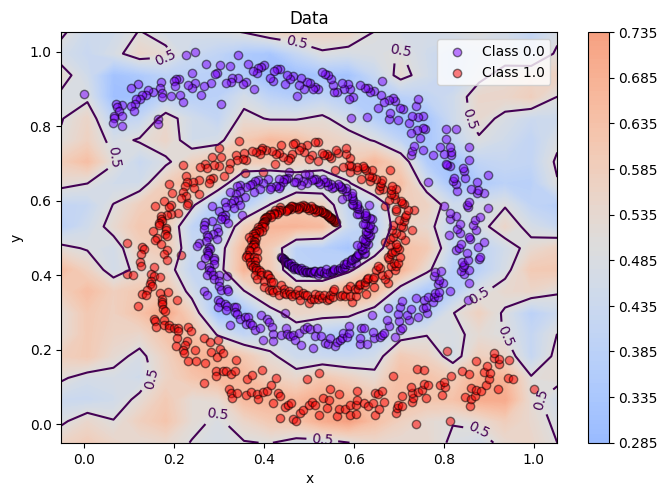

In [ ]:
pl.figure(figsize = (8,16/3))
plot_decision_region(X, preds_plot_dmkdc_qeff)
plot_data(X, y)

In [ ]:
### save or load the model
mode_temp = "load"
date_temp = "050624"
model_temp = "dmkdc_32qeff"
data_set_temp = "Spirals"

if mode_temp == "save":
  save_model(preds_model_train = preds_train_dmkdc_qeff, preds_model_test = preds_test_dmkdc_qeff, preds_model_plot = preds_plot_dmkdc_qeff, data_set_param = data_set_temp,  model_param = model_temp, gamma_param = GAMMA_STRING, date_param = date_temp, mode_param = mode_temp)
if mode_temp == "load":
  preds_train_dmkdc_qeff, preds_test_dmkdc_qeff, preds_plot_dmkdc_qeff = load_model(data_set_param = data_set_temp,  model_param = model_temp, gamma_param = GAMMA_STRING, date_param = date_temp, mode_param = mode_temp)

## Mixed VQ-KCD, QRFF

Ten classes MNIST Classification, QMC variational, with quantum-enhanced Fourier features, no-conv layer

In [ ]:
r = np.random.RandomState(RANDOM_STATE_QRFF)
weights_ffs_temp = r.normal(0, 1, (DIM_X, N_FFS))

weights_ffs_temp.mean(), weights_ffs_temp.std(), weights_ffs_temp.shape

(-0.021105648198196846, 0.98945415704751, (2, 32))

In [ ]:
def predict_features(X_param, var_param, gamma_param):
  X_feat = np.ones((len(X_param), var_param.shape[1]), dtype = np.complex128)
  X_feat[:, :] = np.cos(np.sqrt(gamma_param)*(X_param @ var_param)) - 1j*np.sin(np.sqrt(gamma_param)*(X_param @ var_param))
  X_feat *= np.sqrt(1/(var_param.shape[1]))
  return X_feat

X_feat_train = predict_features(X_train, weights_ffs_temp, GAMMA)
X_feat_test = predict_features(X_test, weights_ffs_temp, GAMMA)
X_feat_plot = predict_features(X_plot, weights_ffs_temp, GAMMA)

X_feat_train.shape, X_feat_test.shape, X_feat_plot.shape

((900, 32), (100, 32), (400, 32))

In [ ]:
## Convert states to unitaries (3,5 mins with 10000)

U_train_conjTrans = np.array([np.conjugate(create_U_train(X_feat_train[i]).T) for i in range(len(X_feat_train))])
U_test_conjTrans = np.array([np.conjugate(create_U_train(X_feat_test[i]).T) for i in range(len(X_feat_test))])
U_plot_conjTrans = np.array([np.conjugate(create_U_train(X_feat_plot[i]).T) for i in range(len(X_feat_plot))])

U_train_conjTrans.shape, U_test_conjTrans.shape, U_plot_conjTrans.shape

((900, 32, 32), (100, 32, 32), (400, 32, 32))

In [ ]:
### Quantum variational KDC with QRFF

import tensorcircuit as tc
from tensorcircuit import keras
import tensorflow as tf

from functools import partial
import numpy as np
import math as m
from scipy.stats import entropy, spearmanr



tc.set_backend("tensorflow")
tc.set_dtype("complex128")

pi = tf.constant(m.pi)


class VQKDC_MIXED_QRFF:
    r"""
    Defines the ready-to-use Quantum measurement classification (QMC) model implemented
    in TensorCircuit using the TensorFlow/Keras API. Any additional argument in the methods has to be Keras-compliant.

    Args:
        auto_compile: A boolean to autocompile the model using default settings. (Default True).
        var_pure_state_size:
        gamma:

    Returns:
        An instantiated model ready to train with ad-hoc data.

    """
    def __init__(self, dim_x_param, n_qeff_qubits, n_ancilla_qubits, num_classes_qubits, num_classes_param, gamma, n_training_data, batch_size = 16, learning_rate = 0.0005, auto_compile=True):

        self.circuit = None
        self.gamma = gamma
        self.dim_x = dim_x_param
        self.num_classes = num_classes_param
        self.num_classes_qubits = num_classes_qubits
        self.n_qeff_qubits = n_qeff_qubits
        self.n_ancilla_qubits = n_ancilla_qubits
        self.n_total_qubits_temp = self.num_classes_qubits + self.n_qeff_qubits + self.n_ancilla_qubits
        self.num_ffs = 2**self.n_qeff_qubits
        self.n_training_data = n_training_data
        self.var_pure_state_parameters_size = 2*(2**self.n_total_qubits_temp - 1)
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        layer = keras.QuantumLayer(
            partial(self.layer),
            [(self.var_pure_state_parameters_size,)]
            )

        self.model = tf.keras.Sequential([layer])

        if auto_compile:
            self.compile()

    def layer(
            self,
            U_dagger,
            var_pure_state_param,
        ):
        r"""
        Defines a Density Matrix Kernel Density Estimation quantum layer for learning with fixed qaff (Meaning of qaff?). (This function was originally named dmkde_mixed_variational_density_estimation_fixed_qaff)

        Args:
            U_dagger:
            var_pure_state_param:

        Returns:
            The probabilities of :math:`|k\rangle`, `|1\rangle`, ..., `|k\rangle` state for kernel density classification of the classes.
        """

        ### indices pure state
        index_it = iter(np.arange(len(var_pure_state_param)))

        ### indices classes, of ms
        n_qubits_classes_qeff_temp = self.num_classes_qubits + self.n_qeff_qubits
        index_qubit_states = indices_qubits_clases(n_qubits_classes_qeff_temp, self.num_classes) # extract indices of the bit string of classes

        # Instantiate a circuit with the calculated number of qubits.
        self.circuit = tc.Circuit(self.n_total_qubits_temp)

        def circuit_base_ry_n(qc_param, num_qubits_param, target_qubit_param):
            if num_qubits_param == 1:
                qc_param.ry(0, theta = var_pure_state_param[next(index_it)])
            elif num_qubits_param == 2:
                qc_param.ry(target_qubit_param, theta=var_pure_state_param[next(index_it)])
                qc_param.cnot(0, target_qubit_param)
                qc_param.ry(target_qubit_param, theta=var_pure_state_param[next(index_it)])
                return
            else:
                circuit_base_ry_n(qc_param, num_qubits_param-1, target_qubit_param)
                qc_param.cnot(num_qubits_param-2, target_qubit_param)
                circuit_base_ry_n(qc_param, num_qubits_param-1, target_qubit_param)
                target_qubit_param -= 1

        def circuit_base_rz_n(qc_param, num_qubits_param, target_qubit_param):
            if num_qubits_param == 1:
                qc_param.rz(0, theta = var_pure_state_param[next(index_it)])
            elif num_qubits_param == 2:
                qc_param.rz(target_qubit_param, theta=var_pure_state_param[next(index_it)])
                qc_param.cnot(0, target_qubit_param)
                qc_param.rz(target_qubit_param, theta=var_pure_state_param[next(index_it)])
                return
            else:
                circuit_base_rz_n(qc_param, num_qubits_param-1, target_qubit_param)
                qc_param.cnot(num_qubits_param-2, target_qubit_param)
                circuit_base_rz_n(qc_param, num_qubits_param-1, target_qubit_param)
                target_qubit_param -= 1

        # Learning pure state
        for i in range(1, self.n_total_qubits_temp+1):
            circuit_base_ry_n(self.circuit, i, i-1)

        # Learning pure state complex phase
        for j in range(1, self.n_total_qubits_temp+1):
            circuit_base_rz_n(self.circuit, j, j-1)

        # Value to predict
        self.circuit.any(
            *[n for n in range(self.num_classes_qubits, self.n_qeff_qubits + self.num_classes_qubits)], unitary=U_dagger
        )

        # Trace out ancilla qubits, find probability of [000] state for density estimation
        measurement_state = tc.quantum.reduced_density_matrix(
                        self.circuit.state(),
                        cut=[m for m in range(n_qubits_classes_qeff_temp, self.n_total_qubits_temp)])
        measurements_results = tc.backend.real(tf.stack([measurement_state[index_qubit_states[i], index_qubit_states[i]] for i in range(self.num_classes)]))
        return measurements_results

    def custom_categorical_crossentropy(self, y_true, y_pred):
        ## code generated with chat gpt
        """
        Custom implementation of categorical cross-entropy loss function.

        Parameters:
            y_true: Tensor. True labels in one-hot encoded format.
            y_pred: Tensor. Predicted probabilities for each class.

        Returns:
            Tensor. Categorical cross-entropy loss.
        """
        epsilon = 1e-7  # small constant to avoid division by zero
        y_pred = tf.clip_by_value(y_pred, epsilon, np.inf)  # clip values to avoid log(0)
        loss = -(1./self.n_training_data)*tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
        return loss

    def compile(
            self,
            optimizer=tf.keras.optimizers.legacy.Adam, # originally 0.0005
            **kwargs):
        r"""
        Method to compile the model.

        Args:
            optimizer:
            **kwargs: Any additional argument.

        Returns:
            None.
        """
        self.model.compile(
            loss = self.custom_categorical_crossentropy,
            optimizer=optimizer(self.learning_rate),
            metrics=["accuracy"],
            **kwargs
        )
    def fit(self, x_train, y_train, batch_size=16, epochs = 30, **kwargs):
        r"""
        Method to fit (train) the model using the ad-hoc dataset.

        Args:
            x_train:
            y_train:
            batch_size:
            epochs:
            **kwargs: Any additional argument.

        Returns:
            None.
        """

        self.model.fit(x_train, y_train, batch_size = self.batch_size, epochs = epochs, **kwargs)

    def predict(self, x_test):
      r"""
      Method to make predictions with the trained model.

      Args:
          x_test:

      Returns:
          The predictions of the conditional density estimation of the input data.
      """
      return (tf.experimental.numpy.power((self.gamma/(pi)), self.dim_x/2.)*\
          self.model.predict(x_test)).numpy()


In [ ]:
## training the quantum circuit
vqkdc = VQKDC_MIXED_QRFF(dim_x_param = DIM_X, n_qeff_qubits = NUM_QUBITS_FFS, n_ancilla_qubits =  NUM_ANCILLA_QUBITS, num_classes_qubits = NUM_CLASSES_QUBITS, num_classes_param = NUM_CLASSES, n_training_data = N_TRAINING_DATA, gamma=GAMMA, batch_size = BATCH_SIZE, learning_rate = LEARNING_RATE)

vqkdc.fit(U_train_conjTrans, y_train_oh, epochs = EPOCHS)

Epoch 1/200
57/57 [==============================] - 301s 44ms/step - loss: 0.0084 - accuracy: 0.4978
Epoch 2/200
57/57 [==============================] - 3s 45ms/step - loss: 0.0076 - accuracy: 0.4978
Epoch 3/200
57/57 [==============================] - 3s 47ms/step - loss: 0.0072 - accuracy: 0.4978
Epoch 4/200
57/57 [==============================] - 3s 59ms/step - loss: 0.0069 - accuracy: 0.4978
Epoch 5/200
57/57 [==============================] - 4s 75ms/step - loss: 0.0066 - accuracy: 0.4978
Epoch 6/200
57/57 [==============================] - 3s 48ms/step - loss: 0.0063 - accuracy: 0.4978
Epoch 7/200
57/57 [==============================] - 3s 49ms/step - loss: 0.0060 - accuracy: 0.4978
Epoch 8/200
57/57 [==============================] - 3s 49ms/step - loss: 0.0059 - accuracy: 0.4978
Epoch 9/200
57/57 [==============================] - 4s 69ms/step - loss: 0.0057 - accuracy: 0.4978
Epoch 10/200
57/57 [==============================] - 3s 60ms/step - loss: 0.0056 - accuracy: 0.49

In [ ]:
preds_train_vqkdc_qrff = vqkdc.predict(U_train_conjTrans)
preds_test_vqkdc_qrff  = vqkdc.predict(U_test_conjTrans)
preds_plot_vqkdc_qrff  = vqkdc.predict(U_plot_conjTrans)

preds_train_vqkdc_qrff.shape, preds_test_vqkdc_qrff.shape, preds_plot_vqkdc_qrff.shape

13/13 [==============================] - 1s 37ms/step


((900, 2), (100, 2), (400, 2))

### Evaluate

In [ ]:
### Evaluate model
evaluate_class_model(y_true_test_param = y_test, y_pred_test_kdc_param = preds_test_kdc, y_pred_test_model_param = preds_test_vqkdc_qrff, y_plot_kdc_param = preds_plot_kdc, y_plot_model_param = preds_plot_vqkdc_qrff, model_name_param = "VQ-KDC 32 QRFF")

Metrics                                     KDC vs VQ-KDC 32 QRFF
----------------------------------------  -----------------------
Accuracy KDC:                                               1
Accuracy VQ-KDC 32 QRFF:                                    0.84
KL-div KDC vs VQ-KDC 32 QRFF:                               0.712
MAE KDC vs VQ-KDC 32 QRFF:                                  3.482
Spearmann class 0 KDC vs VQ-KDC 32 QRFF:                    0.424
Spearmann class 1 KDC vs VQ-KDC 32 QRFF:                    0.412 



<ipython-input-9-9cba43dc4532>:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,


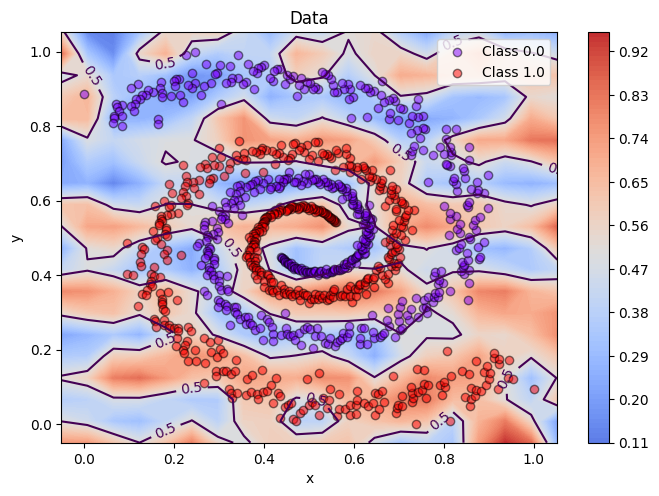

In [ ]:
pl.figure(figsize = (8,16/3))
plot_decision_region(X, preds_plot_vqkdc_qrff)
plot_data(X, y)

In [ ]:
### save or load the model
mode_temp = "load"
date_temp = "050624"
model_temp = "vqkdc_32qrff"
data_set_temp = "Spirals"

if mode_temp == "save":
  save_model(preds_model_train = preds_train_vqkdc_qrff, preds_model_test = preds_test_vqkdc_qrff, preds_model_plot = preds_plot_vqkdc_qrff, data_set_param = data_set_temp,  model_param = model_temp, gamma_param = GAMMA_STRING, date_param = date_temp, mode_param = mode_temp)
elif mode_temp == "load":
  preds_train_vqkdc_qrff, preds_test_vqkdc_qrff, preds_plot_vqkdc_qrff = load_model(data_set_param = data_set_temp,  model_param = model_temp, gamma_param = GAMMA_STRING, date_param = date_temp, mode_param = mode_temp)

## Mixed VQ-KCD, QEFF

Ten classes MNIST Classification, QMC variational, with quantum-enhanced Fourier features, no-conv layer

In [ ]:
### Quantum variational KDC with QEFF

import tensorcircuit as tc
from tensorcircuit import keras
import tensorflow as tf

from functools import partial
import numpy as np
import math as m
from scipy.stats import entropy, spearmanr



tc.set_backend("tensorflow")
tc.set_dtype("complex128")

pi = tf.constant(m.pi)


class VQKDC_MIXED_QEFF:
    r"""
    Defines the ready-to-use Quantum measurement classification (QMC) model implemented
    in TensorCircuit using the TensorFlow/Keras API. Any additional argument in the methods has to be Keras-compliant.

    Args:
        auto_compile: A boolean to autocompile the model using default settings. (Default True).
        var_pure_state_size:
        gamma:

    Returns:
        An instantiated model ready to train with ad-hoc data.

    """
    def __init__(self, dim_x_param, n_qeff_qubits, n_ancilla_qubits, num_classes_qubits, num_classes_param, gamma, n_training_data, batch_size = 16, learning_rate = 0.0005, random_state = 15, auto_compile=True):

        self.circuit = None
        self.gamma = gamma
        self.dim_x = dim_x_param
        self.num_classes = num_classes_param
        self.num_classes_qubits = num_classes_qubits
        self.n_qeff_qubits = n_qeff_qubits
        self.n_ancilla_qubits = n_ancilla_qubits
        self.n_total_qubits_temp = self.num_classes_qubits + self.n_qeff_qubits + self.n_ancilla_qubits
        self.num_ffs = 2**self.n_qeff_qubits
        self.n_training_data = n_training_data
        self.var_pure_state_parameters_size = 2*(2**self.n_total_qubits_temp - 1)
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.qeff_weights = tf.random.normal((dim_x_param, int(self.num_ffs*1-1)), mean = 0.0, stddev = 2.0/np.sqrt(self.num_ffs - 1), dtype=tf.dtypes.float64, seed = random_state)

        layer = keras.QuantumLayer(
            partial(self.layer),
            [(self.var_pure_state_parameters_size,)]
            )

        self.model = tf.keras.Sequential([layer])

        if auto_compile:
            self.compile()

    def layer(
            self,
            x_sample_param,
            var_pure_state_param,
        ):
        r"""
        Defines a Density Matrix Kernel Density Estimation quantum layer for learning with fixed qaff (Meaning of qaff?). (This function was originally named dmkde_mixed_variational_density_estimation_fixed_qaff)

        Args:
            U_dagger:
            var_pure_state_param:

        Returns:
            The probabilities of :math:`|k\rangle`, `|1\rangle`, ..., `|k\rangle` state for kernel density classification of the classes.
        """

        ### indices pure state
        index_it = iter(np.arange(len(var_pure_state_param)))

        ### indices qeff
        index_iter_qeff = iter(np.arange(self.qeff_weights.shape[1]))

        ### indices classes, of ms
        n_qubits_classes_qeff_temp = self.num_classes_qubits + self.n_qeff_qubits
        index_qubit_states = indices_qubits_clases(n_qubits_classes_qeff_temp, self.num_classes) # extract indices of the bit string of classes


        # Instantiate a circuit with the calculated number of qubits.
        self.circuit = tc.Circuit(self.n_total_qubits_temp)

        def circuit_base_ry_n(qc_param, num_qubits_param, target_qubit_param):
            if num_qubits_param == 1:
                qc_param.ry(0, theta = var_pure_state_param[next(index_it)])
            elif num_qubits_param == 2:
                qc_param.ry(target_qubit_param, theta=var_pure_state_param[next(index_it)])
                qc_param.cnot(0, target_qubit_param)
                qc_param.ry(target_qubit_param, theta=var_pure_state_param[next(index_it)])
                return
            else:
                circuit_base_ry_n(qc_param, num_qubits_param-1, target_qubit_param)
                qc_param.cnot(num_qubits_param-2, target_qubit_param)
                circuit_base_ry_n(qc_param, num_qubits_param-1, target_qubit_param)
                target_qubit_param -= 1

        def circuit_base_rz_n(qc_param, num_qubits_param, target_qubit_param):
            if num_qubits_param == 1:
                qc_param.rz(0, theta = var_pure_state_param[next(index_it)])
            elif num_qubits_param == 2:
                qc_param.rz(target_qubit_param, theta=var_pure_state_param[next(index_it)])
                qc_param.cnot(0, target_qubit_param)
                qc_param.rz(target_qubit_param, theta=var_pure_state_param[next(index_it)])
                return
            else:
                circuit_base_rz_n(qc_param, num_qubits_param-1, target_qubit_param)
                qc_param.cnot(num_qubits_param-2, target_qubit_param)
                circuit_base_rz_n(qc_param, num_qubits_param-1, target_qubit_param)
                target_qubit_param -= 1

        # Learning pure state
        for i in range(1, self.n_total_qubits_temp+1):
            circuit_base_ry_n(self.circuit, i, i-1)

        # Learning pure state complex phase
        for j in range(1, self.n_total_qubits_temp+1):
            circuit_base_rz_n(self.circuit, j, j-1)

        # Value to predict

        x_sample_temp = tf.expand_dims(x_sample_param, axis=0)
        phases_temp = (tf.cast(tf.sqrt(self.gamma), tf.float64)*tf.linalg.matmul(tf.cast(x_sample_temp, tf.float64), self.qeff_weights))[0]
        init_qubit_qeff_temp = self.num_classes_qubits # qubit at which the qaff mapping starts it starts after the qubits of the classes

        def circuit_base_rz_qeff_n(qc_param, num_qubits_param, target_qubit_param, init_qubit_param):
          if num_qubits_param == 1:
            qc_param.rz(init_qubit_param, theta = phases_temp[next(index_iter_qeff)] )
          elif num_qubits_param == 2:
            qc_param.rz(target_qubit_param + init_qubit_param, theta = phases_temp[next(index_iter_qeff)])
            qc_param.cnot(init_qubit_param, target_qubit_param + init_qubit_param)
            qc_param.rz(target_qubit_param + init_qubit_param, theta = phases_temp[next(index_iter_qeff)])
            return
          else:
            circuit_base_rz_qeff_n(qc_param, num_qubits_param-1, target_qubit_param, init_qubit_param)
            qc_param.cnot(num_qubits_param-2 + init_qubit_param, target_qubit_param + init_qubit_param)
            circuit_base_rz_qeff_n(qc_param, num_qubits_param-1, target_qubit_param, init_qubit_param)
            target_qubit_param -= 1

        # Applying the QEFF feature map

        for i in reversed(range(1, self.n_qeff_qubits + 1)):
          circuit_base_rz_qeff_n(self.circuit, i, i - 1, init_qubit_qeff_temp)

        for i in range(init_qubit_qeff_temp, init_qubit_qeff_temp + self.n_qeff_qubits):
          self.circuit.H(i)

        # Trace out ancilla qubits, find probability of [000] state for density estimation
        measurement_state = tc.quantum.reduced_density_matrix(
                        self.circuit.state(),
                        cut=[m for m in range(n_qubits_classes_qeff_temp, self.n_total_qubits_temp)])
        measurements_results = tc.backend.real(tf.stack([measurement_state[index_qubit_states[i], index_qubit_states[i]] for i in range(self.num_classes)]))
        return measurements_results

    def custom_categorical_crossentropy(self, y_true, y_pred):
        ## code generated with chat gpt
        """
        Custom implementation of categorical cross-entropy loss function.

        Parameters:
            y_true: Tensor. True labels in one-hot encoded format.
            y_pred: Tensor. Predicted probabilities for each class.

        Returns:
            Tensor. Categorical cross-entropy loss.
        """
        epsilon = 1e-7  # small constant to avoid division by zero
        y_pred = tf.clip_by_value(y_pred, epsilon, np.inf)  # clip values to avoid log(0) originaly 1.0 - epsilon
        loss = -(1./self.n_training_data)*tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
        return loss

    def compile(
            self,
            optimizer=tf.keras.optimizers.legacy.Adam, # originally 0.0005
            **kwargs):
        r"""
        Method to compile the model.

        Args:
            optimizer:
            **kwargs: Any additional argument.

        Returns:
            None.
        """
        self.model.compile(
            loss = self.custom_categorical_crossentropy,
            optimizer=optimizer(self.learning_rate),
            metrics=["accuracy"],
            **kwargs
        )
    def fit(self, x_train, y_train, batch_size=16, epochs = 30, **kwargs):
        r"""
        Method to fit (train) the model using the ad-hoc dataset.

        Args:
            x_train:
            y_train:
            batch_size:
            epochs:
            **kwargs: Any additional argument.

        Returns:
            None.
        """

        self.model.fit(x_train, y_train, batch_size = self.batch_size, epochs = epochs, **kwargs)

    def predict(self, x_test):
      r"""
      Method to make predictions with the trained model.

      Args:
          x_test:

      Returns:
          The predictions of the conditional density estimation of the input data.
      """
      return (tf.experimental.numpy.power((self.gamma/(pi)), self.dim_x/2.)*\
          self.model.predict(x_test)).numpy()


In [ ]:
## training the quantum circuit
vqkdc = VQKDC_MIXED_QEFF(dim_x_param = DIM_X, n_qeff_qubits = NUM_QUBITS_FFS, n_ancilla_qubits =  NUM_ANCILLA_QUBITS, num_classes_qubits = NUM_CLASSES_QUBITS, num_classes_param = NUM_CLASSES, n_training_data = N_TRAINING_DATA, gamma=GAMMA, batch_size = BATCH_SIZE, learning_rate = LEARNING_RATE, random_state = RANDOM_STATE_QEFF)

vqkdc.fit(X_train, y_train_oh, epochs = EPOCHS)

Epoch 1/100
57/57 [==============================] - 347s 84ms/step - loss: 0.0082 - accuracy: 0.4978
Epoch 2/100
57/57 [==============================] - 3s 54ms/step - loss: 0.0074 - accuracy: 0.4978
Epoch 3/100
57/57 [==============================] - 3s 55ms/step - loss: 0.0070 - accuracy: 0.4978
Epoch 4/100
57/57 [==============================] - 3s 59ms/step - loss: 0.0067 - accuracy: 0.4978
Epoch 5/100
57/57 [==============================] - 5s 89ms/step - loss: 0.0064 - accuracy: 0.4978
Epoch 6/100
57/57 [==============================] - 3s 57ms/step - loss: 0.0062 - accuracy: 0.4978
Epoch 7/100
57/57 [==============================] - 3s 56ms/step - loss: 0.0059 - accuracy: 0.4978
Epoch 8/100
57/57 [==============================] - 3s 59ms/step - loss: 0.0056 - accuracy: 0.4978
Epoch 9/100
57/57 [==============================] - 5s 92ms/step - loss: 0.0054 - accuracy: 0.4978
Epoch 10/100
57/57 [==============================] - 3s 57ms/step - loss: 0.0052 - accuracy: 0.49

In [ ]:
vqkdc.fit(X_train, y_train_oh, epochs = EPOCHS)

Epoch 1/100
57/57 [==============================] - 8s 136ms/step - loss: 0.0031 - accuracy: 0.8133
Epoch 2/100
57/57 [==============================] - 6s 113ms/step - loss: 0.0031 - accuracy: 0.8133
Epoch 3/100
57/57 [==============================] - 3s 59ms/step - loss: 0.0031 - accuracy: 0.8167
Epoch 4/100
57/57 [==============================] - 5s 87ms/step - loss: 0.0031 - accuracy: 0.8144
Epoch 5/100
57/57 [==============================] - 3s 56ms/step - loss: 0.0031 - accuracy: 0.8211
Epoch 6/100
57/57 [==============================] - 3s 56ms/step - loss: 0.0031 - accuracy: 0.8178
Epoch 7/100
57/57 [==============================] - 3s 56ms/step - loss: 0.0031 - accuracy: 0.8200
Epoch 8/100
57/57 [==============================] - 5s 90ms/step - loss: 0.0031 - accuracy: 0.8167
Epoch 9/100
57/57 [==============================] - 3s 55ms/step - loss: 0.0031 - accuracy: 0.8200
Epoch 10/100
57/57 [==============================] - 5s 88ms/step - loss: 0.0031 - accuracy: 0.82

In [ ]:
preds_train_vqkdc_qeff = vqkdc.predict(X_train)
preds_test_vqkdc_qeff  = vqkdc.predict(X_test)
preds_plot_vqkdc_qeff  = vqkdc.predict(X_plot)

preds_train_vqkdc_qeff.shape, preds_test_vqkdc_qeff.shape, preds_plot_vqkdc_qeff.shape

13/13 [==============================] - 0s 27ms/step


((900, 2), (100, 2), (400, 2))

### Evaluate

In [ ]:
### Evaluate model
evaluate_class_model(y_true_test_param = y_test, y_pred_test_kdc_param = preds_test_kdc, y_pred_test_model_param = preds_test_vqkdc_qeff, y_plot_kdc_param = preds_plot_kdc, y_plot_model_param = preds_plot_vqkdc_qeff, model_name_param = "VQ-KDC 32 QEFF")

Metrics                                     KDC vs VQ-KDC 32 QEFF
----------------------------------------  -----------------------
Accuracy KDC:                                               1
Accuracy VQ-KDC 32 QEFF:                                    0.82
KL-div KDC vs VQ-KDC 32 QEFF:                               0.335
MAE KDC vs VQ-KDC 32 QEFF:                                  2.033
Spearmann class 0 KDC vs VQ-KDC 32 QEFF:                    0.8
Spearmann class 1 KDC vs VQ-KDC 32 QEFF:                    0.795 



<ipython-input-9-9cba43dc4532>:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,


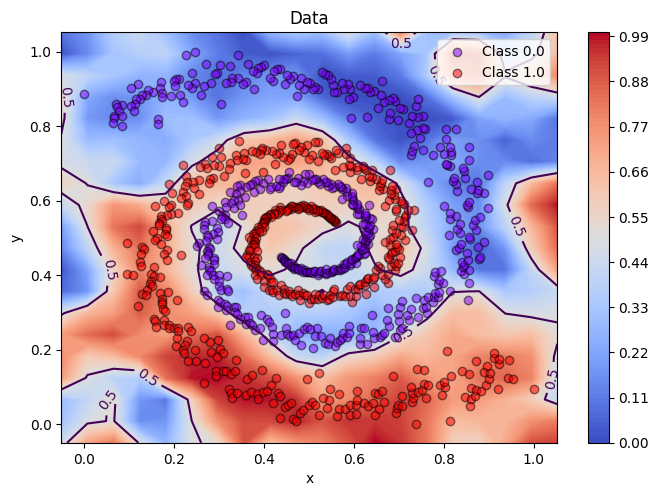

In [ ]:
pl.figure(figsize = (8,16/3))
plot_decision_region(X, preds_plot_vqkdc_qeff)
plot_data(X, y)

In [ ]:
### save or load the model
mode_temp = "load"
date_temp = "050624"
model_temp = "vqkdc_32qeff"
data_set_temp = "Spirals"

if mode_temp == "save":
  save_model(preds_model_train = preds_train_vqkdc_qeff, preds_model_test = preds_test_vqkdc_qeff, preds_model_plot = preds_plot_vqkdc_qeff, data_set_param = data_set_temp,  model_param = model_temp, gamma_param = GAMMA_STRING, date_param = date_temp, mode_param = mode_temp)
elif mode_temp == "load":
  preds_train_vqkdc_qeff, preds_test_vqkdc_qeff, preds_plot_vqkdc_qeff = load_model(data_set_param = data_set_temp,  model_param = model_temp, gamma_param = GAMMA_STRING, date_param = date_temp, mode_param = mode_temp)

## Constants HEA

In [ ]:
## Change these values accordingly

DATA_SET = "Spirals" ## change dataset accordingly
NUM_QUBITS_FFS = 5 ## set 6 for the final experiments
NUM_ANCILLA_QUBITS = 2 # set 2 for the final experiments
GRID_SIZE = X_plot[1] - X_plot[0]
NUM_CLASSES = 2
NUM_CLASSES_QUBITS = 1
BATCH_SIZE = 16

#######

GAMMA_DICT = {"Moons": float(2**7), "Circles": float(2**6), "Spirals": float(2**8)}
GAMMA_STRING_DICT = {"Moons": "2ala7", "Circles": "2ala6", "Spirals": "2ala8"}
RANDOM_STATE_QRFF_DICT = {"Moons": 324, "Circles": 125, "Spirals": 345}
RANDOM_STATE_QEFF_DICT = {"Moons": 3, "Circles": 15, "Spirals": 56}
EPOCHS_DICT  = {"Moons": 50, "Circles": 100, "Spirals": 200}
LEARNING_RATE_DICT = {"Moons": 0.002, "Circles": 0.001, "Spirals": 0.001}
GAMMA = GAMMA_DICT[DATA_SET]
GAMMA_STRING = GAMMA_STRING_DICT[DATA_SET]
RANDOM_STATE_QRFF = RANDOM_STATE_QRFF_DICT[DATA_SET]
RANDOM_STATE_QEFF = RANDOM_STATE_QEFF_DICT[DATA_SET]
LEARNING_RATE = LEARNING_RATE_DICT[DATA_SET]
EPOCHS = EPOCHS_DICT[DATA_SET]
DIM_X = X_train.shape[1]
N_TRAINING_DATA = X_train.shape[0]
N_FFS = 2**NUM_QUBITS_FFS
NUM_LAYERS_HEA = 3 ## set 3 for the final experiments
NUM_TOTAL_QUBITS = NUM_QUBITS_FFS + NUM_ANCILLA_QUBITS + NUM_CLASSES_QUBITS

###

DATA_SET, EPOCHS, NUM_QUBITS_FFS, NUM_ANCILLA_QUBITS, GAMMA, RANDOM_STATE_QRFF, RANDOM_STATE_QEFF, DIM_X, N_FFS, NUM_LAYERS_HEA, LEARNING_RATE, N_TRAINING_DATA, GAMMA_STRING

('Spirals', 200, 5, 2, 256.0, 345, 56, 2, 32, 3, 0.001, 900, '2ala8')

## Mixed VQ-KCD, QRFF HEA

Ten classes MNIST Classification, QMC variational, with quantum-enhanced Fourier features, no-conv layer

In [ ]:
r = np.random.RandomState(RANDOM_STATE_QRFF)
weights_ffs_temp = r.normal(0, 1, (DIM_X, N_FFS))

weights_ffs_temp.mean(), weights_ffs_temp.std(), weights_ffs_temp.shape

(-0.14098322424751247, 0.9494580523137711, (2, 32))

In [ ]:
def predict_features(X_param, var_param, gamma_param):
  X_feat = np.ones((len(X_param), var_param.shape[1]), dtype = np.complex128)
  X_feat[:, :] = np.cos(np.sqrt(gamma_param)*(X_param @ var_param)) - 1j*np.sin(np.sqrt(gamma_param)*(X_param @ var_param))
  X_feat *= np.sqrt(1/(var_param.shape[1]))
  return X_feat

X_feat_train = predict_features(X_train, weights_ffs_temp, GAMMA)
X_feat_test = predict_features(X_test, weights_ffs_temp, GAMMA)
X_feat_plot = predict_features(X_plot, weights_ffs_temp, GAMMA)

X_feat_train.shape, X_feat_test.shape, X_feat_plot.shape

((1800, 32), (200, 32), (400, 32))

In [ ]:
## Convert states to unitaries (3,5 mins with 10000)

U_train_conjTrans = np.array([np.conjugate(create_U_train(X_feat_train[i]).T) for i in range(len(X_feat_train))])
U_test_conjTrans = np.array([np.conjugate(create_U_train(X_feat_test[i]).T) for i in range(len(X_feat_test))])
U_plot_conjTrans = np.array([np.conjugate(create_U_train(X_feat_plot[i]).T) for i in range(len(X_feat_plot))])

U_train_conjTrans.shape, U_test_conjTrans.shape, U_plot_conjTrans.shape

((1800, 32, 32), (200, 32, 32), (400, 32, 32))

In [ ]:
### Quantum variational KDC with QRFF

import tensorcircuit as tc
from tensorcircuit import keras
import tensorflow as tf

from functools import partial
import numpy as np
import math as m

tc.set_backend("tensorflow")
tc.set_dtype("complex128")

pi = tf.constant(m.pi)


class VQKDC_MIXED_QRFF_HEA:
    r"""
    Defines the ready-to-use Quantum measurement classification (QMC) model implemented
    in TensorCircuit using the TensorFlow/Keras API. Any additional argument in the methods has to be Keras-compliant.

    Args:
        auto_compile: A boolean to autocompile the model using default settings. (Default True).
        var_pure_state_size:
        gamma:

    Returns:
        An instantiated model ready to train with ad-hoc data.

    """
    def __init__(self, dim_x_param, n_qeff_qubits, n_ancilla_qubits, num_classes_qubits, num_classes_param, gamma, n_training_data, num_layers_hea = 3, batch_size = 16, learning_rate = 0.0005, auto_compile=True):

        self.circuit = None
        self.gamma = gamma
        self.dim_x = dim_x_param
        self.num_layers_hea = num_layers_hea
        self.num_classes = num_classes_param
        self.num_classes_qubits = num_classes_qubits
        self.n_qeff_qubits = n_qeff_qubits
        self.n_ancilla_qubits = n_ancilla_qubits
        self.n_total_qubits_temp = self.num_classes_qubits + self.n_qeff_qubits + self.n_ancilla_qubits
        self.num_ffs = 2**self.n_qeff_qubits
        self.n_training_data = n_training_data
        self.var_hea_ansatz_size = int(self.n_total_qubits_temp*(self.num_layers_hea+1)*2)
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        layer = keras.QuantumLayer(
            partial(self.layer),
            [(self.var_hea_ansatz_size,)]
            )

        self.model = tf.keras.Sequential([layer])

        if auto_compile:
            self.compile()

    def layer(
            self,
            U_dagger,
            var_hea_ansatz_param,
        ):
        r"""
        Defines a Density Matrix Kernel Density Estimation quantum layer for learning with fixed qaff (Meaning of qaff?). (This function was originally named dmkde_mixed_variational_density_estimation_fixed_qaff)

        Args:
            U_dagger:
            var_pure_state_param:

        Returns:
            The probabilities of :math:`|k\rangle`, `|1\rangle`, ..., `|k\rangle` state for kernel density classification of the classes.
        """

        ### indices pure state hea
        index_iter_hea  = iter(np.arange(len(var_hea_ansatz_param)))

        ### indices classes, of ms
        n_qubits_classes_qeff_temp = self.num_classes_qubits + self.n_qeff_qubits
        index_qubit_states = indices_qubits_clases(n_qubits_classes_qeff_temp, self.num_classes) # extract indices of the bit string of classes

        # Instantiate a circuit with the calculated number of qubits.
        self.circuit = tc.Circuit(self.n_total_qubits_temp)


        def hea_ansatz(qc_param, num_qubits_param, num_layers_param):
          # encoding
          for i in range (0, num_qubits_param):
            qc_param.ry(i, theta = var_hea_ansatz_param[next(index_iter_hea)])
            qc_param.rz(i, theta = var_hea_ansatz_param[next(index_iter_hea)])
          # layers
          for j in range(num_layers_param):
            for i in range (0, num_qubits_param-1):
              qc_param.CNOT(i, i+1)

            for i in range (0, num_qubits_param):
              qc_param.ry(i, theta= var_hea_ansatz_param[next(index_iter_hea)])
              qc_param.rz(i, theta= var_hea_ansatz_param[next(index_iter_hea)])

        ## learning pure state with HEA
        hea_ansatz(self.circuit, self.n_total_qubits_temp, self.num_layers_hea)

        # Value to predict
        self.circuit.any(
            *[n for n in range(self.num_classes_qubits, self.n_qeff_qubits + self.num_classes_qubits)], unitary=U_dagger
        )

        # Trace out ancilla qubits, find probability of [000] state for density estimation
        measurement_state = tc.quantum.reduced_density_matrix(
                        self.circuit.state(),
                        cut=[m for m in range(n_qubits_classes_qeff_temp, self.n_total_qubits_temp)])
        measurements_results = tc.backend.real(tf.stack([measurement_state[index_qubit_states[i], index_qubit_states[i]] for i in range(self.num_classes)]))
        return measurements_results

    def custom_categorical_crossentropy(self, y_true, y_pred):
        ## code generated with chat gpt
        """
        Custom implementation of categorical cross-entropy loss function.

        Parameters:
            y_true: Tensor. True labels in one-hot encoded format.
            y_pred: Tensor. Predicted probabilities for each class.

        Returns:
            Tensor. Categorical cross-entropy loss.
        """
        epsilon = 1e-7  # small constant to avoid division by zero
        y_pred = tf.clip_by_value(y_pred, epsilon, np.inf)  # clip values to avoid log(0)
        loss = -(1./self.n_training_data)*tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
        return loss

    def compile(
            self,
            optimizer=tf.keras.optimizers.legacy.Adam, # originally 0.0005
            **kwargs):
        r"""
        Method to compile the model.

        Args:
            optimizer:
            **kwargs: Any additional argument.

        Returns:
            None.
        """
        self.model.compile(
            loss = self.custom_categorical_crossentropy,
            optimizer=optimizer(self.learning_rate),
            metrics=["accuracy"],
            **kwargs
        )
    def fit(self, x_train, y_train, batch_size=16, epochs = 30, **kwargs):
        r"""
        Method to fit (train) the model using the ad-hoc dataset.

        Args:
            x_train:
            y_train:
            batch_size:
            epochs:
            **kwargs: Any additional argument.

        Returns:
            None.
        """

        self.model.fit(x_train, y_train, batch_size = self.batch_size, epochs = epochs, **kwargs)

    def predict(self, x_test):
      r"""
      Method to make predictions with the trained model.

      Args:
          x_test:

      Returns:
          The predictions of the conditional density estimation of the input data.
      """
      return (tf.experimental.numpy.power((self.gamma/(pi)), self.dim_x/2.)*\
          self.model.predict(x_test)).numpy()


In [ ]:
## training the quantum circuit
vqkdc = VQKDC_MIXED_QRFF_HEA(dim_x_param = DIM_X, n_qeff_qubits = NUM_QUBITS_FFS, n_ancilla_qubits =  NUM_ANCILLA_QUBITS, num_classes_qubits = NUM_CLASSES_QUBITS, num_classes_param = NUM_CLASSES, n_training_data = N_TRAINING_DATA, gamma=GAMMA, num_layers_hea = NUM_LAYERS_HEA, batch_size = BATCH_SIZE, learning_rate = LEARNING_RATE)

vqkdc.fit(U_train_conjTrans, y_train_oh, epochs = EPOCHS)

Epoch 1/200
57/57 [==============================] - 24s 22ms/step - loss: 0.0063 - accuracy: 0.4978
Epoch 2/200
57/57 [==============================] - 1s 22ms/step - loss: 0.0058 - accuracy: 0.4978
Epoch 3/200
57/57 [==============================] - 1s 21ms/step - loss: 0.0055 - accuracy: 0.4978
Epoch 4/200
57/57 [==============================] - 1s 22ms/step - loss: 0.0053 - accuracy: 0.4978
Epoch 5/200
57/57 [==============================] - 2s 32ms/step - loss: 0.0051 - accuracy: 0.4978
Epoch 6/200
57/57 [==============================] - 2s 36ms/step - loss: 0.0050 - accuracy: 0.4978
Epoch 7/200
57/57 [==============================] - 2s 35ms/step - loss: 0.0049 - accuracy: 0.4978
Epoch 8/200
57/57 [==============================] - 1s 22ms/step - loss: 0.0048 - accuracy: 0.4978
Epoch 9/200
57/57 [==============================] - 1s 22ms/step - loss: 0.0047 - accuracy: 0.4978
Epoch 10/200
57/57 [==============================] - 1s 22ms/step - loss: 0.0046 - accuracy: 0.503

In [ ]:
preds_train_vqkdc_qrff_hea = vqkdc.predict(U_train_conjTrans)
preds_test_vqkdc_qrff_hea  = vqkdc.predict(U_test_conjTrans)
preds_plot_vqkdc_qrff_hea  = vqkdc.predict(U_plot_conjTrans)

preds_train_vqkdc_qrff_hea.shape, preds_test_vqkdc_qrff_hea.shape, preds_plot_vqkdc_qrff_hea.shape

13/13 [==============================] - 0s 19ms/step


((900, 2), (100, 2), (400, 2))

### Evaluate

In [ ]:
### Evaluate model
evaluate_class_model(y_true_test_param = y_test, y_pred_test_kdc_param = preds_test_kdc, y_pred_test_model_param = preds_test_vqkdc_qrff_hea, y_plot_kdc_param = preds_plot_kdc, y_plot_model_param = preds_plot_vqkdc_qrff_hea, model_name_param = f"VQ-KDC HEA {N_FFS} QRFF")

Metrics                                         KDC vs VQ-KDC HEA 32 QRFF
--------------------------------------------  ---------------------------
Accuracy KDC:                                                       1
Accuracy VQ-KDC HEA 32 QRFF:                                        0.65
KL-div KDC vs VQ-KDC HEA 32 QRFF:                                   0.985
MAE KDC vs VQ-KDC HEA 32 QRFF:                                      2.306
Spearmann class 0 KDC vs VQ-KDC HEA 32 QRFF:                        0.307
Spearmann class 1 KDC vs VQ-KDC HEA 32 QRFF:                        0.291 



<ipython-input-9-9cba43dc4532>:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,


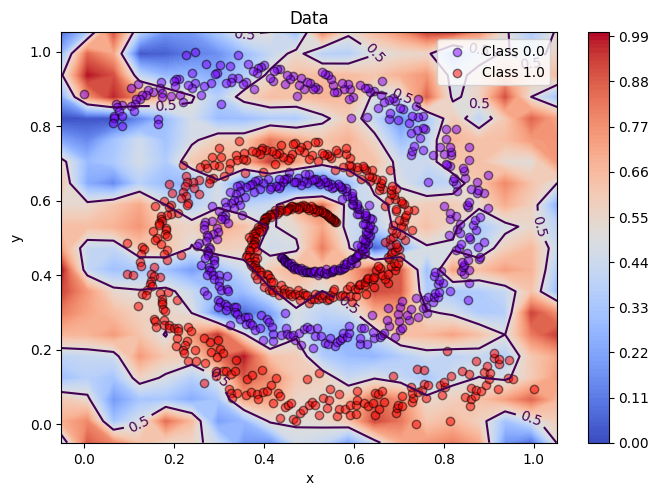

In [ ]:
pl.figure(figsize = (8,16/3))
plot_decision_region(X, preds_plot_vqkdc_qrff_hea)
plot_data(X, y)

In [ ]:
### save or load the model
mode_temp = "load"
date_temp = "050624"
model_temp = "vqkdc_32qrff_hea"
data_set_temp = "Spirals"

if mode_temp == "save":
  save_model(preds_model_train = preds_train_vqkdc_qrff_hea, preds_model_test = preds_test_vqkdc_qrff_hea, preds_model_plot = preds_plot_vqkdc_qrff_hea, data_set_param = data_set_temp,  model_param = model_temp, gamma_param = GAMMA_STRING, date_param = date_temp, mode_param = mode_temp)
elif mode_temp == "load":
  preds_train_vqkdc_qrff_hea, preds_test_vqkdc_qrff_hea, preds_plot_vqkdc_qrff_hea = load_model(data_set_param = data_set_temp,  model_param = model_temp, gamma_param = GAMMA_STRING, date_param = date_temp, mode_param = mode_temp)

## Mixed VQ-KCD, QEFF, HEA

Ten classes MNIST Classification, QMC variational, with quantum-enhanced Fourier features, and Hardware Efficient Ansatz

In [ ]:
### Quantum variational KDC with QEFF

import tensorcircuit as tc
from tensorcircuit import keras
import tensorflow as tf

from functools import partial
import numpy as np
import math as m
from scipy.stats import entropy, spearmanr



tc.set_backend("tensorflow")
tc.set_dtype("complex128")

pi = tf.constant(m.pi)


class VQKDC_MIXED_QEFF_HEA:
    r"""
    Defines the ready-to-use Quantum measurement classification (QMC) model implemented
    in TensorCircuit using the TensorFlow/Keras API. Any additional argument in the methods has to be Keras-compliant.

    Args:
        auto_compile: A boolean to autocompile the model using default settings. (Default True).
        var_pure_state_size:
        gamma:

    Returns:
        An instantiated model ready to train with ad-hoc data.

    """
    def __init__(self, dim_x_param, n_qeff_qubits, n_ancilla_qubits, num_classes_qubits, num_classes_param, gamma, n_training_data, num_layers_hea = 3, batch_size = 16, learning_rate = 0.0005, random_state = 15, auto_compile=True):

        self.circuit = None
        self.gamma = gamma
        self.dim_x = dim_x_param
        self.num_layers_hea = num_layers_hea
        self.num_classes = num_classes_param
        self.num_classes_qubits = num_classes_qubits
        self.n_qeff_qubits = n_qeff_qubits
        self.n_ancilla_qubits = n_ancilla_qubits
        self.n_total_qubits_temp = self.num_classes_qubits + self.n_qeff_qubits + self.n_ancilla_qubits
        self.num_ffs = 2**self.n_qeff_qubits
        self.n_training_data = n_training_data
        self.var_hea_ansatz_size = int(self.n_total_qubits_temp*(self.num_layers_hea+1)*2)
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.qeff_weights = tf.random.normal((dim_x_param, int(self.num_ffs*1-1)), mean = 0.0, stddev = 2.0/np.sqrt(self.num_ffs - 1), dtype=tf.dtypes.float64, seed = random_state)

        layer = keras.QuantumLayer(
            partial(self.layer),
            [(self.var_hea_ansatz_size,)]
            )

        self.model = tf.keras.Sequential([layer])

        if auto_compile:
            self.compile()

    def layer(
            self,
            x_sample_param,
            var_hea_ansatz_param,
        ):
        r"""
        Defines a Density Matrix Kernel Density Estimation quantum layer for learning with fixed qaff (Meaning of qaff?). (This function was originally named dmkde_mixed_variational_density_estimation_fixed_qaff)

        Args:
            U_dagger:
            var_pure_state_param:

        Returns:
            The probabilities of :math:`|k\rangle`, `|1\rangle`, ..., `|k\rangle` state for kernel density classification of the classes.
        """

        ### indices pure state hea
        index_iter_hea  = iter(np.arange(len(var_hea_ansatz_param)))

        ### indices qeff
        index_iter_qeff = iter(np.arange(self.qeff_weights.shape[1]))

        ### indices classes, of ms
        n_qubits_classes_qeff_temp = self.num_classes_qubits + self.n_qeff_qubits
        index_qubit_states = indices_qubits_clases(n_qubits_classes_qeff_temp, self.num_classes) # extract indices of the bit string of classes


        # Instantiate a circuit with the calculated number of qubits.
        self.circuit = tc.Circuit(self.n_total_qubits_temp)

        def hea_ansatz(qc_param, num_qubits_param, num_layers_param):
          # encoding
          for i in range (0, num_qubits_param):
            qc_param.ry(i, theta = var_hea_ansatz_param[next(index_iter_hea)])
            qc_param.rz(i, theta = var_hea_ansatz_param[next(index_iter_hea)])
          # layers
          for j in range(num_layers_param):
            for i in range (0, num_qubits_param-1):
              qc_param.CNOT(i, i+1)

            for i in range (0, num_qubits_param):
              qc_param.ry(i, theta= var_hea_ansatz_param[next(index_iter_hea)])
              qc_param.rz(i, theta= var_hea_ansatz_param[next(index_iter_hea)])

        ## learning pure state with HEA
        hea_ansatz(self.circuit, self.n_total_qubits_temp, self.num_layers_hea)

        # Value to predict

        x_sample_temp = tf.expand_dims(x_sample_param, axis=0)
        phases_temp = (tf.cast(tf.sqrt(self.gamma), tf.float64)*tf.linalg.matmul(tf.cast(x_sample_temp, tf.float64), self.qeff_weights))[0]
        init_qubit_qeff_temp = self.num_classes_qubits # qubit at which the qaff mapping starts it starts after the qubits of the classes

        def circuit_base_rz_qeff_n(qc_param, num_qubits_param, target_qubit_param, init_qubit_param):
          if num_qubits_param == 1:
            qc_param.rz(init_qubit_param, theta = phases_temp[next(index_iter_qeff)] )
          elif num_qubits_param == 2:
            qc_param.rz(target_qubit_param + init_qubit_param, theta = phases_temp[next(index_iter_qeff)])
            qc_param.cnot(init_qubit_param, target_qubit_param + init_qubit_param)
            qc_param.rz(target_qubit_param + init_qubit_param, theta = phases_temp[next(index_iter_qeff)])
            return
          else:
            circuit_base_rz_qeff_n(qc_param, num_qubits_param-1, target_qubit_param, init_qubit_param)
            qc_param.cnot(num_qubits_param-2 + init_qubit_param, target_qubit_param + init_qubit_param)
            circuit_base_rz_qeff_n(qc_param, num_qubits_param-1, target_qubit_param, init_qubit_param)
            target_qubit_param -= 1

        # Applying the QEFF feature map

        for i in reversed(range(1, self.n_qeff_qubits + 1)):
          circuit_base_rz_qeff_n(self.circuit, i, i - 1, init_qubit_qeff_temp)

        for i in range(init_qubit_qeff_temp, init_qubit_qeff_temp + self.n_qeff_qubits):
          self.circuit.H(i)

        # Trace out ancilla qubits, find probability of [000] state for density estimation
        measurement_state = tc.quantum.reduced_density_matrix(
                        self.circuit.state(),
                        cut=[m for m in range(n_qubits_classes_qeff_temp, self.n_total_qubits_temp)])
        measurements_results = tc.backend.real(tf.stack([measurement_state[index_qubit_states[i], index_qubit_states[i]] for i in range(self.num_classes)]))
        return measurements_results

    def custom_categorical_crossentropy(self, y_true, y_pred):
        ## code generated with chat gpt
        """
        Custom implementation of categorical cross-entropy loss function.

        Parameters:
            y_true: Tensor. True labels in one-hot encoded format.
            y_pred: Tensor. Predicted probabilities for each class.

        Returns:
            Tensor. Categorical cross-entropy loss.
        """
        epsilon = 1e-7  # small constant to avoid division by zero
        y_pred = tf.clip_by_value(y_pred, epsilon, np.inf)  # clip values to avoid log(0) originaly 1.0 - epsilon
        loss = -(1./self.n_training_data)*tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
        return loss

    def compile(
            self,
            optimizer=tf.keras.optimizers.legacy.Adam, # originally 0.0005
            **kwargs):
        r"""
        Method to compile the model.

        Args:
            optimizer:
            **kwargs: Any additional argument.

        Returns:
            None.
        """
        self.model.compile(
            loss = self.custom_categorical_crossentropy,
            optimizer=optimizer(self.learning_rate),
            metrics=["accuracy"],
            **kwargs
        )
    def fit(self, x_train, y_train, batch_size=16, epochs = 30, **kwargs):
        r"""
        Method to fit (train) the model using the ad-hoc dataset.

        Args:
            x_train:
            y_train:
            batch_size:
            epochs:
            **kwargs: Any additional argument.

        Returns:
            None.
        """

        self.model.fit(x_train, y_train, batch_size = self.batch_size, epochs = epochs, **kwargs)

    def predict(self, x_test):
      r"""
      Method to make predictions with the trained model.

      Args:
          x_test:

      Returns:
          The predictions of the conditional density estimation of the input data.
      """
      return (tf.experimental.numpy.power((self.gamma/(pi)), self.dim_x/2.)*\
          self.model.predict(x_test)).numpy()


In [ ]:
## training the quantum circuit
vqkdc = VQKDC_MIXED_QEFF_HEA(dim_x_param = DIM_X, n_qeff_qubits = NUM_QUBITS_FFS, n_ancilla_qubits =  NUM_ANCILLA_QUBITS, num_classes_qubits = NUM_CLASSES_QUBITS, num_classes_param = NUM_CLASSES, n_training_data = N_TRAINING_DATA, gamma=GAMMA, num_layers_hea = NUM_LAYERS_HEA, batch_size = BATCH_SIZE, learning_rate = LEARNING_RATE, random_state = RANDOM_STATE_QEFF)

vqkdc.fit(X_train, y_train_oh, epochs = EPOCHS)

Epoch 1/200
57/57 [==============================] - 85s 46ms/step - loss: 0.0060 - accuracy: 0.4978
Epoch 2/200
57/57 [==============================] - 2s 36ms/step - loss: 0.0056 - accuracy: 0.4978
Epoch 3/200
57/57 [==============================] - 2s 39ms/step - loss: 0.0053 - accuracy: 0.4978
Epoch 4/200
57/57 [==============================] - 2s 39ms/step - loss: 0.0051 - accuracy: 0.4978
Epoch 5/200
57/57 [==============================] - 2s 35ms/step - loss: 0.0050 - accuracy: 0.4978
Epoch 6/200
57/57 [==============================] - 2s 39ms/step - loss: 0.0048 - accuracy: 0.4978
Epoch 7/200
57/57 [==============================] - 3s 45ms/step - loss: 0.0047 - accuracy: 0.4978
Epoch 8/200
57/57 [==============================] - 3s 45ms/step - loss: 0.0046 - accuracy: 0.5056
Epoch 9/200
57/57 [==============================] - 2s 34ms/step - loss: 0.0045 - accuracy: 0.5389
Epoch 10/200
57/57 [==============================] - 2s 31ms/step - loss: 0.0045 - accuracy: 0.567

In [ ]:
preds_train_vqkdc_qeff_hea = vqkdc.predict(X_train)
preds_test_vqkdc_qeff_hea  = vqkdc.predict(X_test)
preds_plot_vqkdc_qeff_hea  = vqkdc.predict(X_plot)

preds_train_vqkdc_qeff_hea.shape, preds_test_vqkdc_qeff_hea.shape, preds_plot_vqkdc_qeff_hea.shape

13/13 [==============================] - 0s 14ms/step


((900, 2), (100, 2), (400, 2))

### Evaluate

In [ ]:
### Evaluate model
evaluate_class_model(y_true_test_param = y_test, y_pred_test_kdc_param = preds_test_kdc, y_pred_test_model_param = preds_test_vqkdc_qeff_hea, y_plot_kdc_param = preds_plot_kdc, y_plot_model_param = preds_plot_vqkdc_qeff_hea, model_name_param = f"VQ-KDC HEA {N_FFS} QEFF")

Metrics                                         KDC vs VQ-KDC HEA 32 QEFF
--------------------------------------------  ---------------------------
Accuracy KDC:                                                       1
Accuracy VQ-KDC HEA 32 QEFF:                                        0.83
KL-div KDC vs VQ-KDC HEA 32 QEFF:                                   0.721
MAE KDC vs VQ-KDC HEA 32 QEFF:                                      1.221
Spearmann class 0 KDC vs VQ-KDC HEA 32 QEFF:                        0.563
Spearmann class 1 KDC vs VQ-KDC HEA 32 QEFF:                        0.36 



<ipython-input-9-9cba43dc4532>:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,


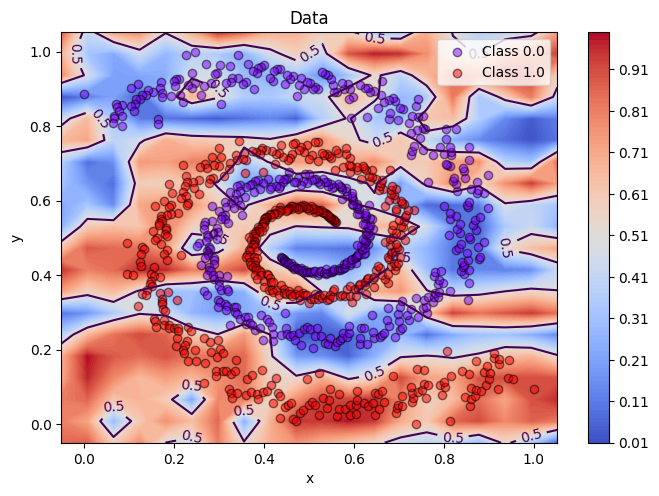

In [ ]:
pl.figure(figsize = (8,16/3))
plot_decision_region(X, preds_plot_vqkdc_qeff_hea)
plot_data(X, y)

In [ ]:
### save or load the model
mode_temp = "load"
date_temp = "050624"
model_temp = "vqkdc_32qeff_hea"
data_set_temp = "Spirals"


if mode_temp == "save":
  save_model(preds_model_train = preds_train_vqkdc_qeff_hea, preds_model_test = preds_test_vqkdc_qeff_hea, preds_model_plot = preds_plot_vqkdc_qeff_hea, data_set_param = data_set_temp,  model_param = model_temp, gamma_param = GAMMA_STRING, date_param = date_temp, mode_param = mode_temp)
elif mode_temp == "load":
  preds_train_vqkdc_qeff_hea, preds_test_vqkdc_qeff_hea, preds_plot_vqkdc_qeff_hea = load_model(data_set_param = data_set_temp,  model_param = model_temp, gamma_param = GAMMA_STRING, date_param = date_temp, mode_param = mode_temp)

# Draft code

In [ ]:
import numpy as np

def negative_log_likelihood_one_hot(y_true, y_pred):
    """
    Compute the Negative Log Likelihood loss for one-hot encoded labels.

    Parameters:
    y_true (numpy.ndarray): One-hot encoded true labels, shape (n_samples, n_classes).
    y_pred (numpy.ndarray): Predicted probabilities, shape (n_samples, n_classes).

    Returns:
    float: Negative Log Likelihood loss.
    """
    # Ensure y_pred is within (0, 1) to avoid log(0)
    epsilon = 1e-7
    y_pred = np.clip(y_pred, epsilon, np.inf)

    # Calculate the negative log likelihood
    nll = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

    return nll

print("Negative Log Likelihood:", negative_log_likelihood_one_hot(y_train_oh.numpy(), preds_train_kdc))

Negative Log Likelihood: 2.4275419965826455


In [ ]:
def kl_divergence(p, q):
    """
    Compute the Kullback-Leibler Divergence between two probability distributions.

    Parameters:
    p (numpy.ndarray): True probability distribution (n_samples, n_classes).
    q (numpy.ndarray): Approximating probability distribution (n_samples, n_classes).

    Returns:
    float: Kullback-Leibler Divergence.
    """
    # Ensure the distributions are valid (i.e., within (0, 1) and sum to 1)
    epsilon = 1e-15
    p = np.clip(p, epsilon, np.inf)
    q = np.clip(q, epsilon, np.inf)

    # Normalize the distributions to ensure they sum to 1
    #p = p / np.sum(p, axis=1, keepdims=True)
    #q = q / np.sum(q, axis=1, keepdims=True)

    # Calculate the KL Divergence
    kl_div = np.sum(p * np.log(p / q), axis=1)

    return np.sum(kl_div)

kl_div = kl_divergence(preds_plot_dmkdc, preds_plot)*GRID_SIZE
kl_div

array([-0.10263675])